In [1]:
import  cv2
from xihua import *
import  PIL
import  numpy as np
from ImageUtil import  *
import matplotlib.pyplot as plt

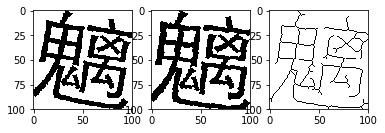

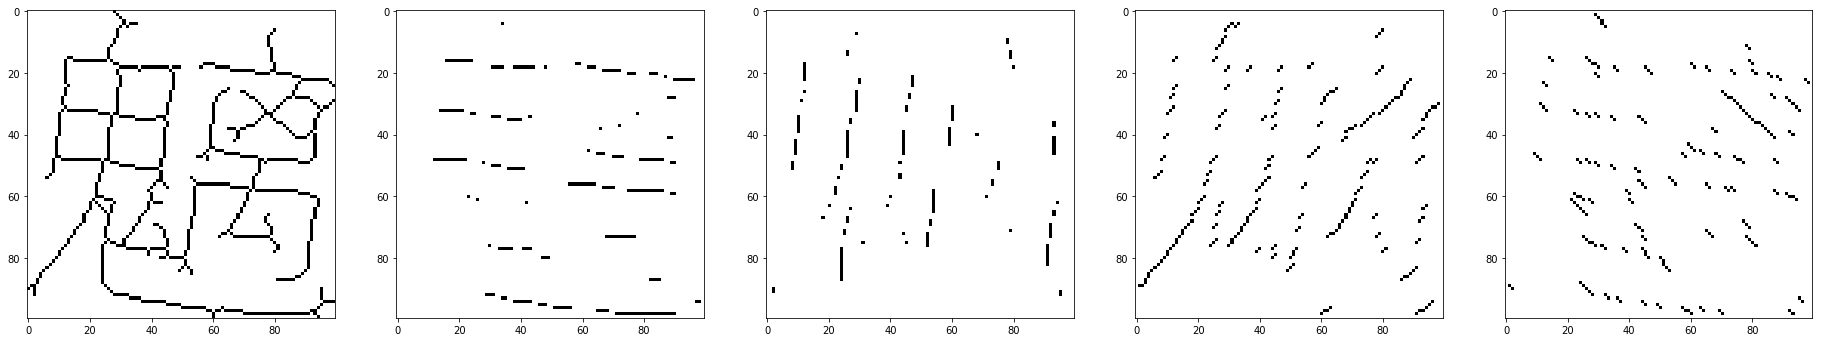

[ 0.04186047  0.03125     0.04        0.03431373  0.06046512  0.          0.028
  0.03431373  0.0372093   0.08125     0.036       0.03431373  0.          0.0625
  0.028       0.01960784  0.00930233  0.0375      0.016       0.01960784
  0.04186047  0.          0.02        0.02941176  0.06511628  0.03125
  0.024       0.04411765  0.01395349  0.00625     0.008       0.01960784
  0.          0.          0.024       0.0245098   0.05116279  0.          0.036
  0.04411765  0.00930233  0.03125     0.04        0.0245098   0.          0.0125
  0.04        0.03431373  0.05116279  0.1         0.028       0.0245098   0.
  0.05        0.012       0.          0.          0.04375     0.032
  0.00490196  0.04651163  0.01875     0.024       0.04901961  0.00930233
  0.01875     0.02        0.04411765  0.00465116  0.01875     0.032
  0.02941176  0.0372093   0.04375     0.036       0.05392157  0.01395349
  0.0375      0.02        0.03431373  0.06046512  0.          0.008
  0.02941176  0.04651163  0.03125  

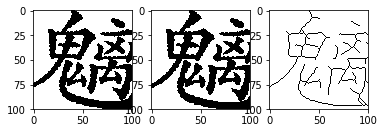

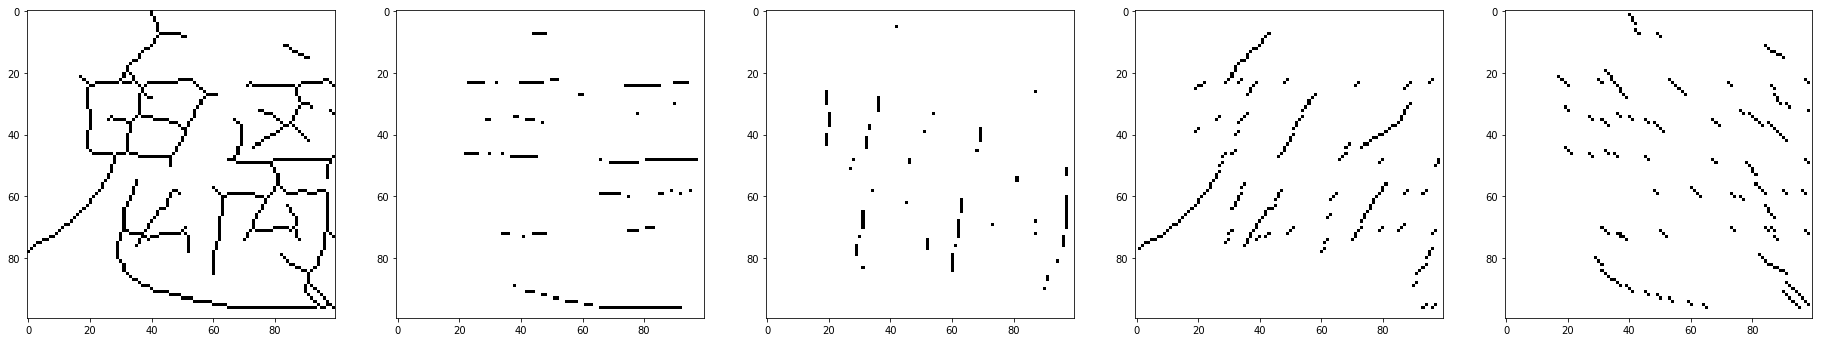

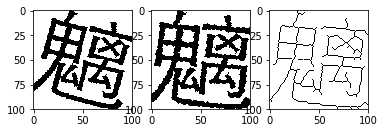

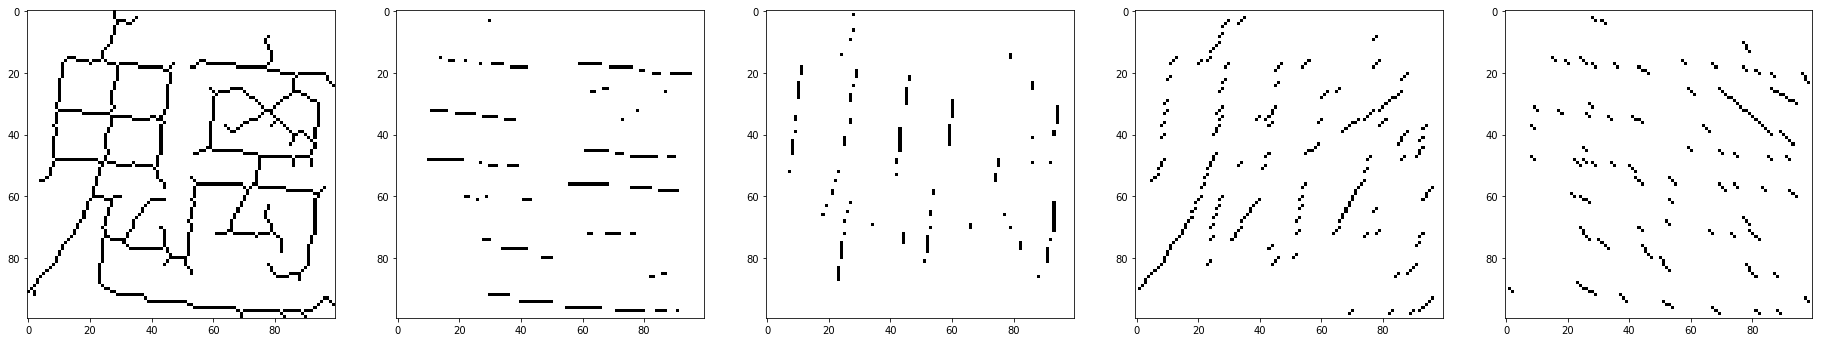

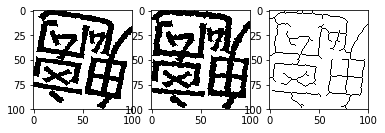

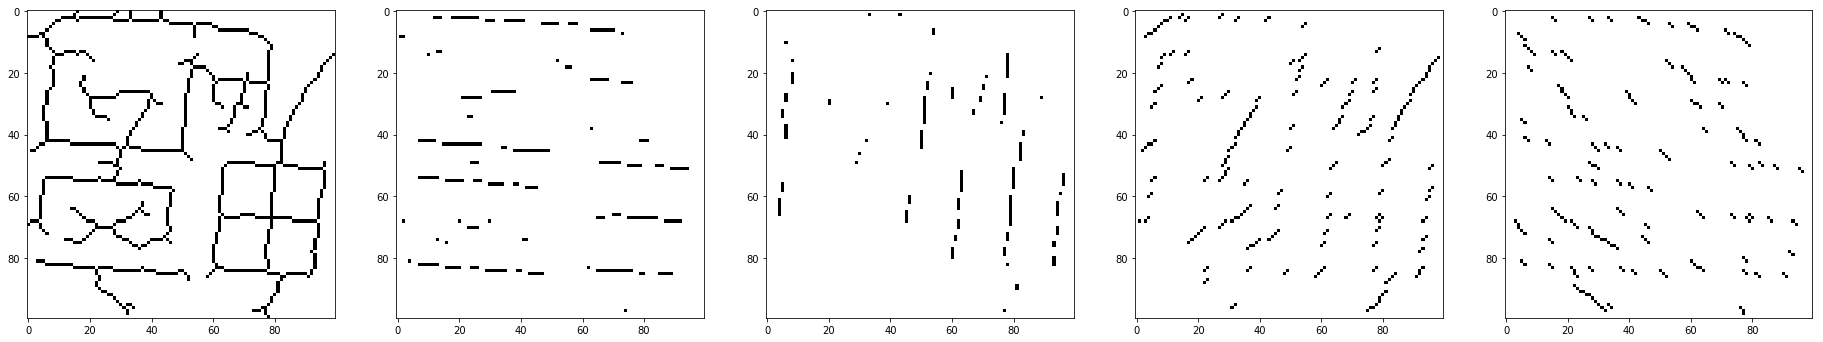

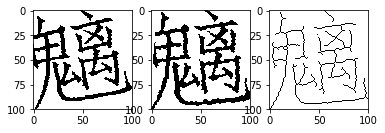

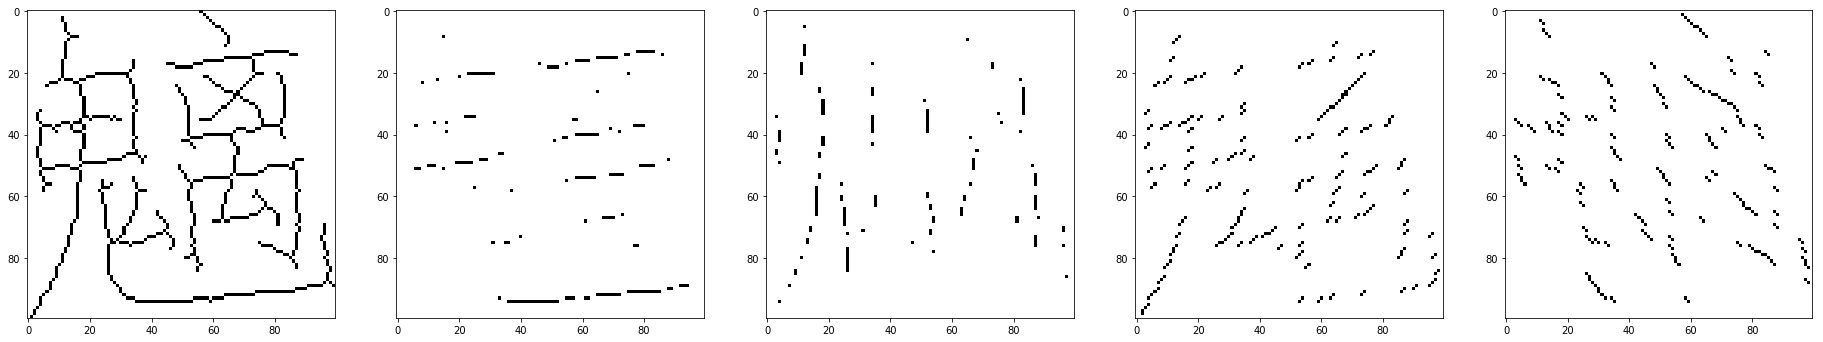

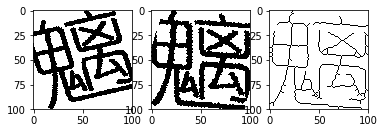

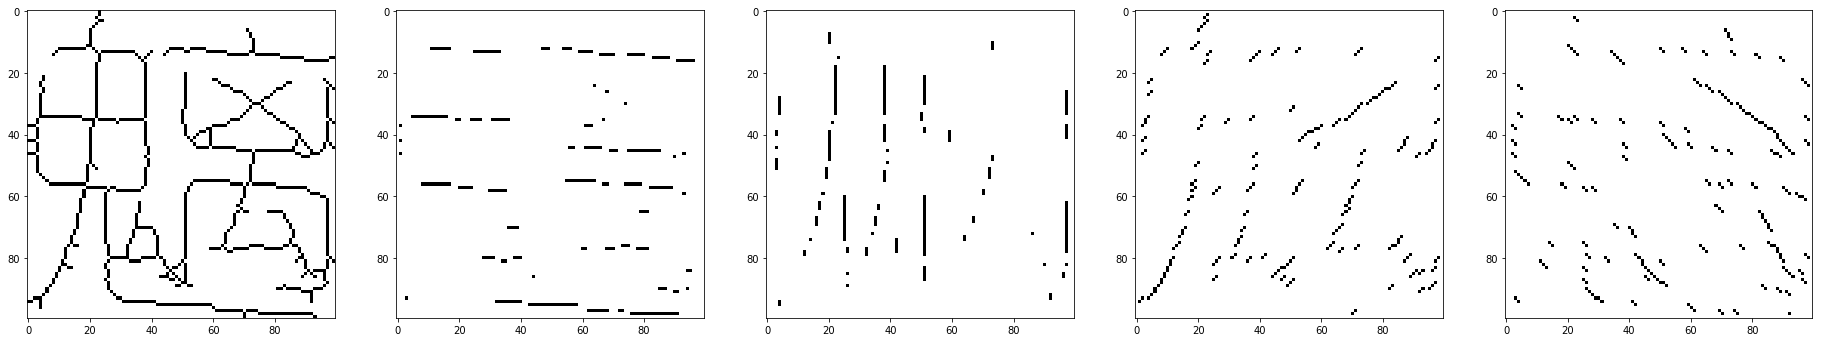

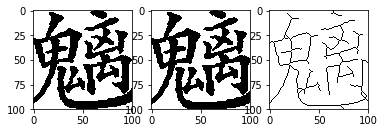

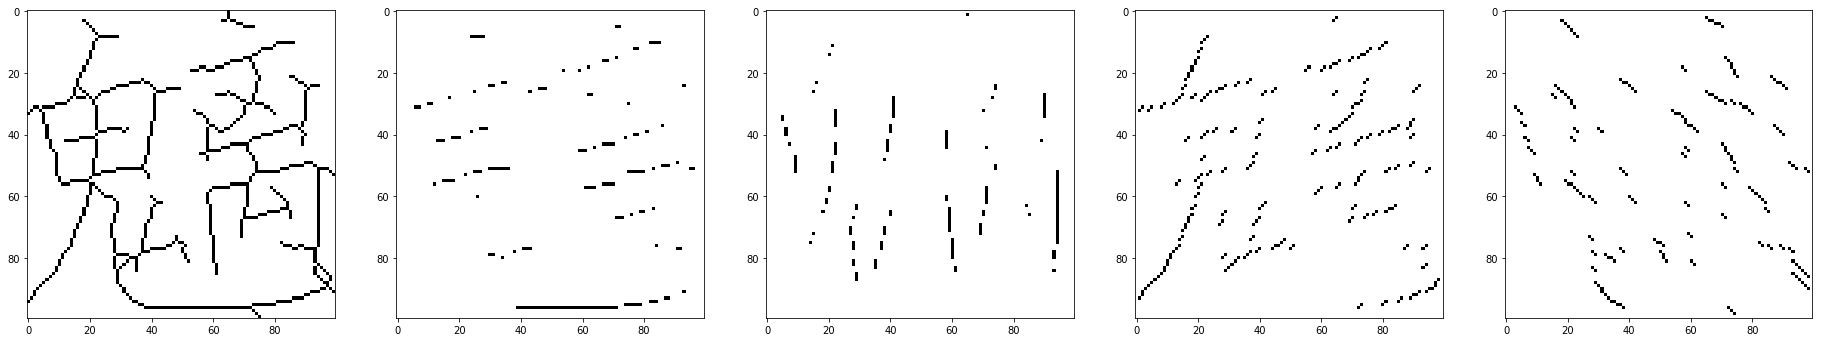

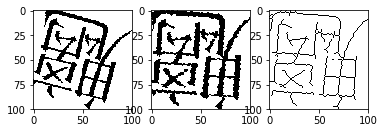

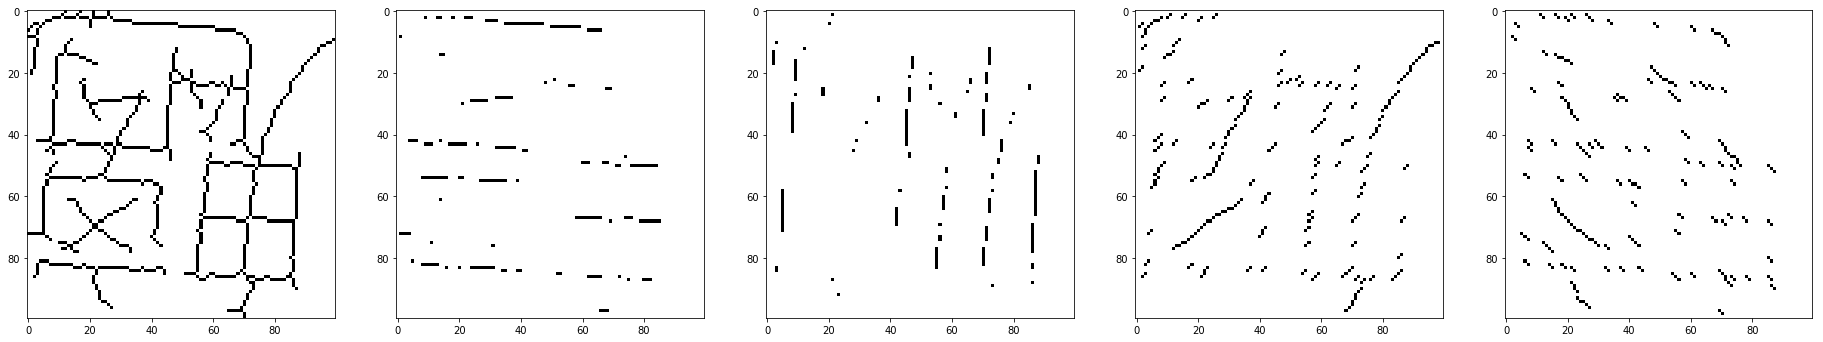

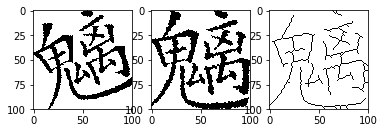

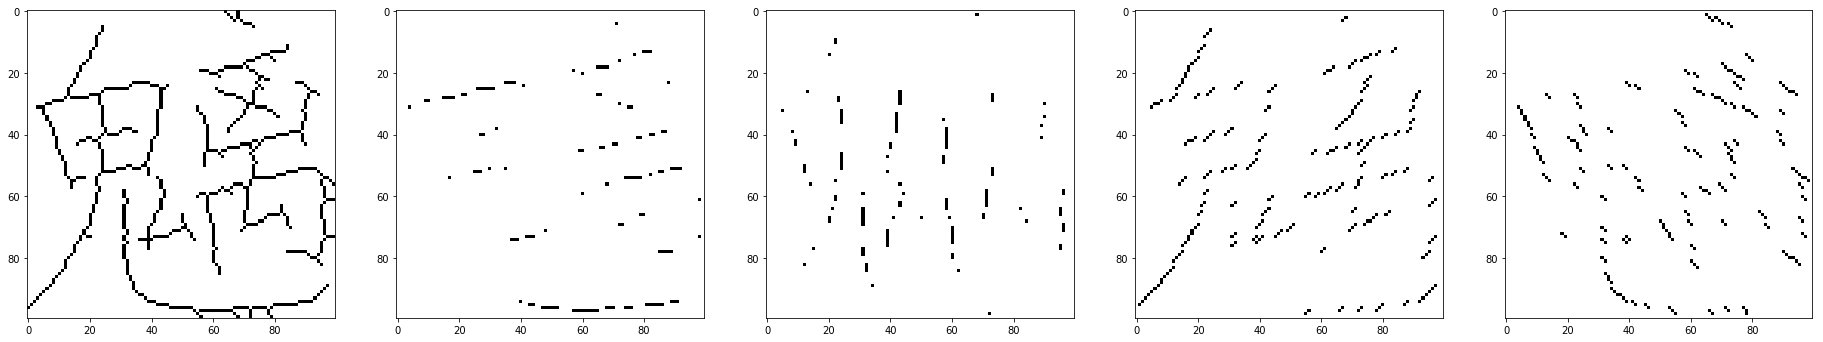

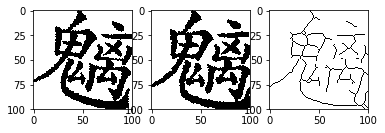

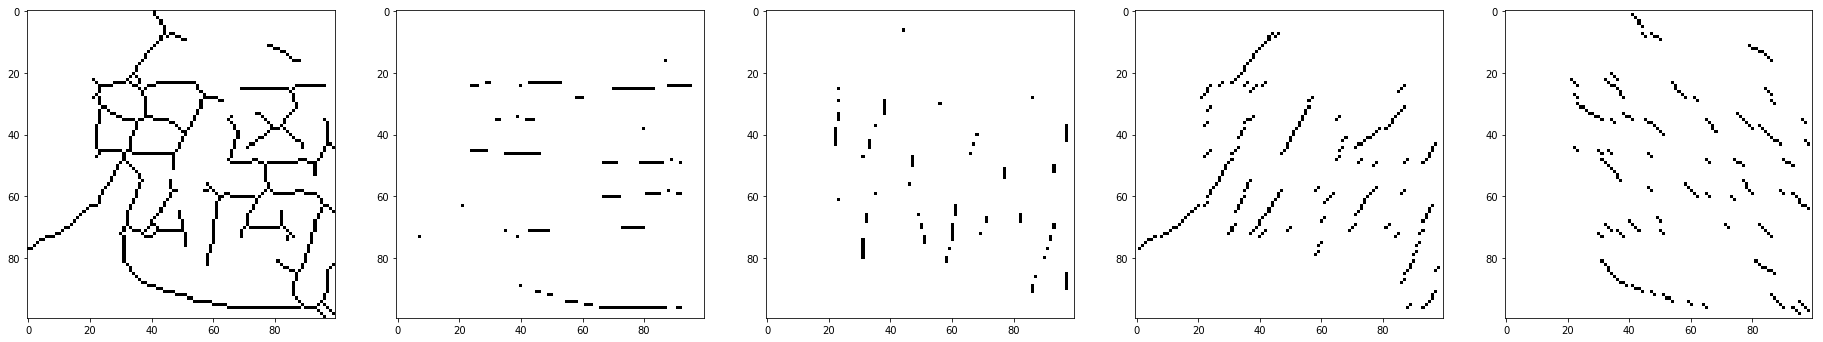

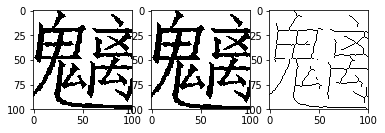

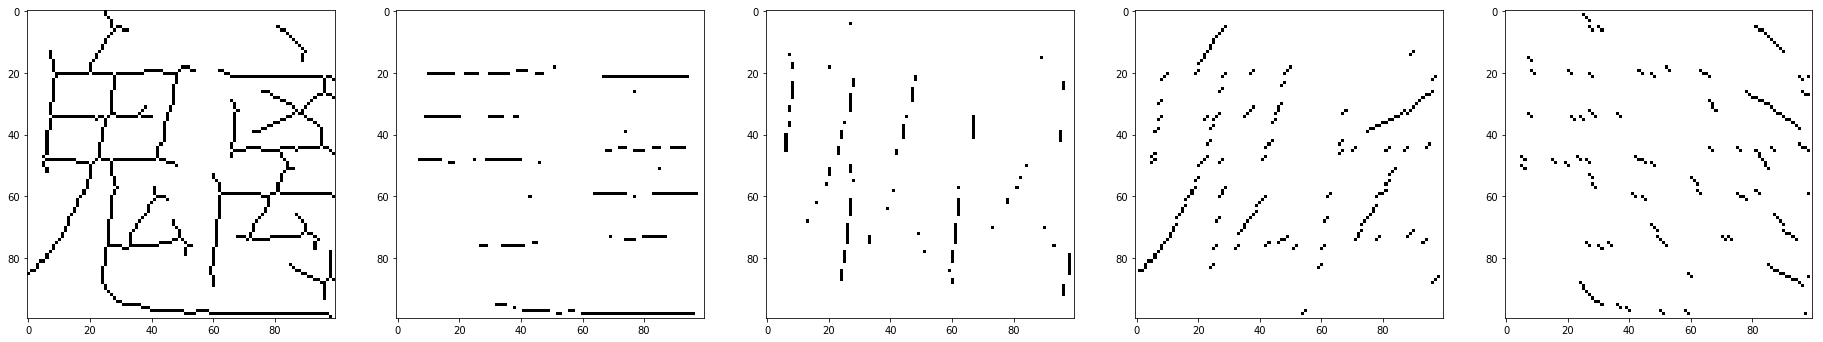

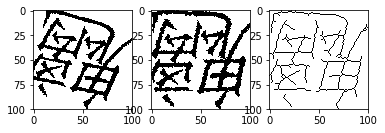

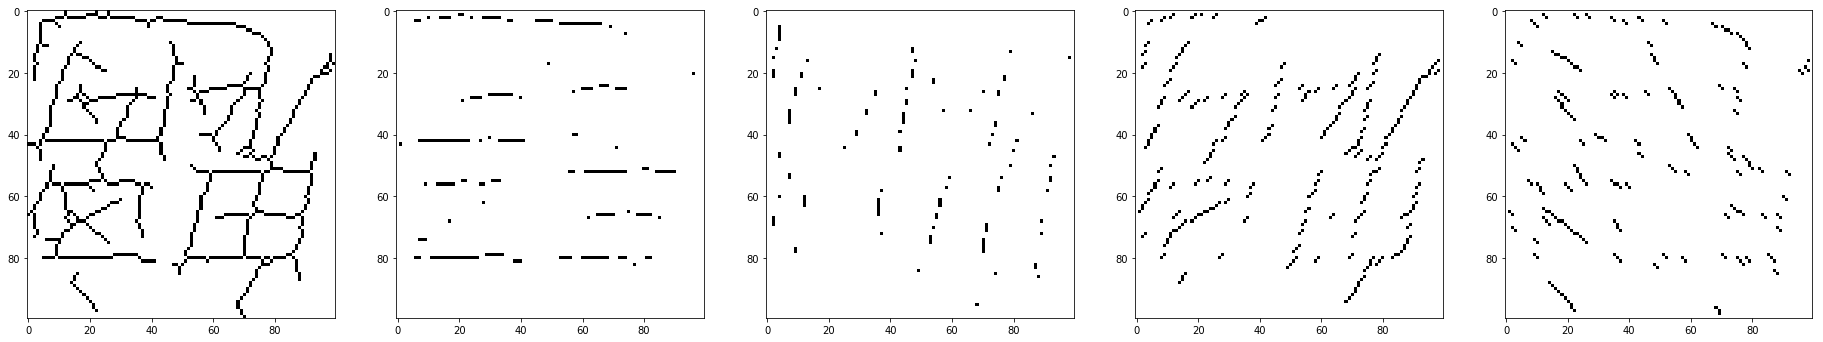

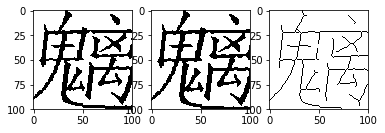

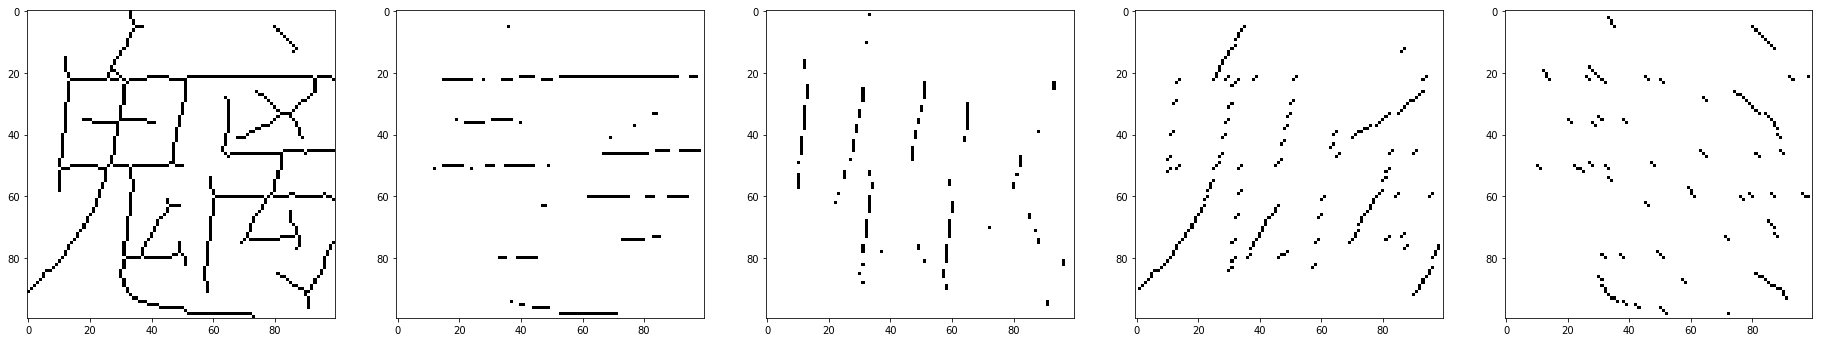

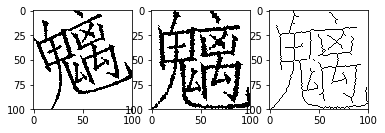

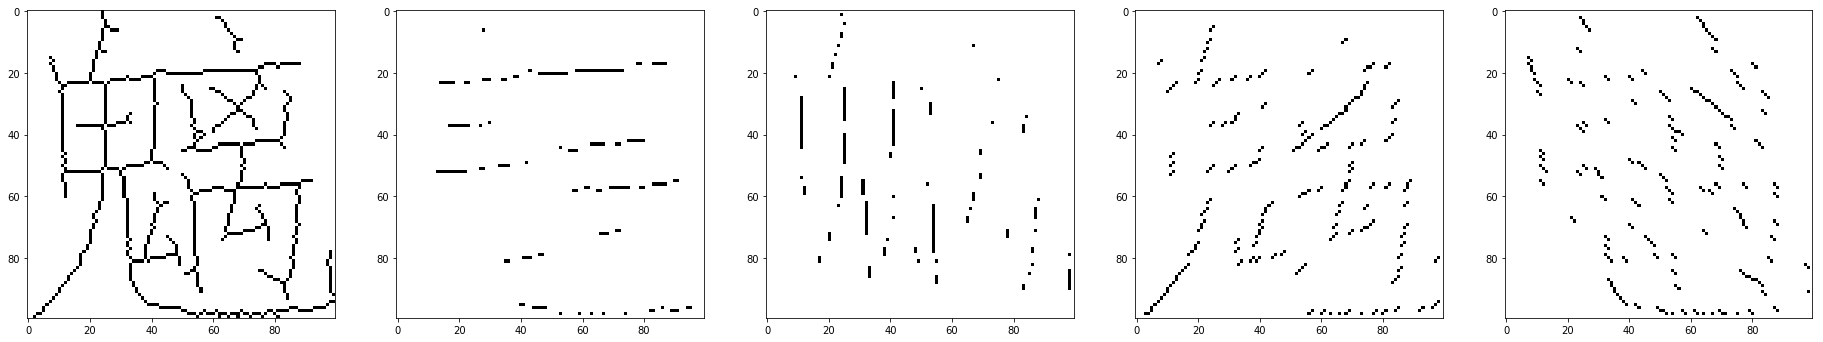

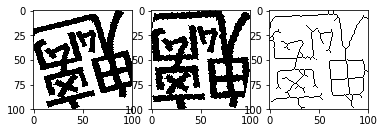

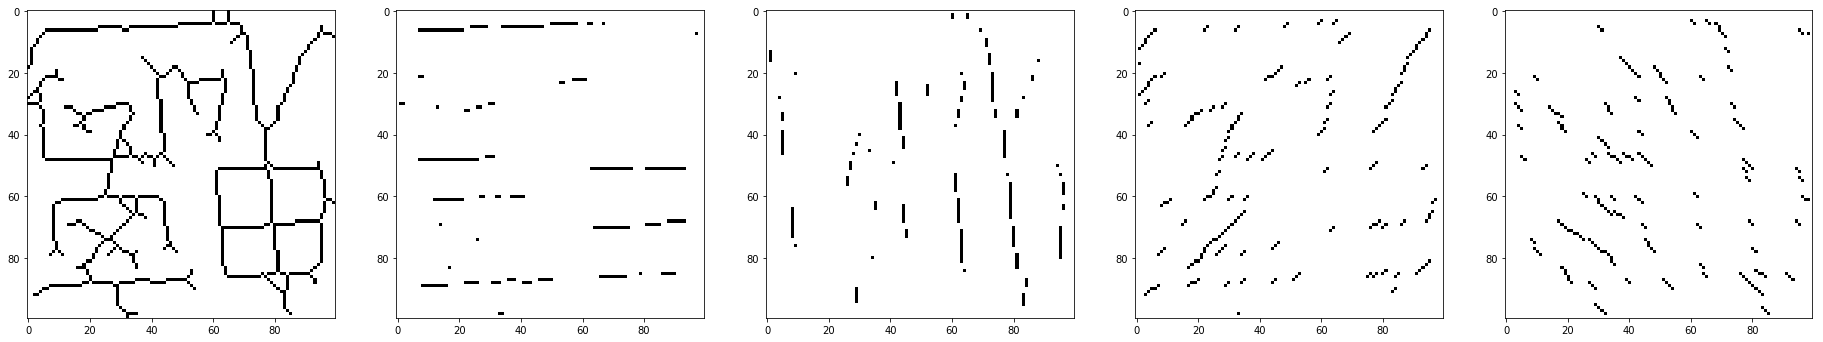

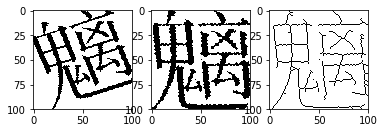

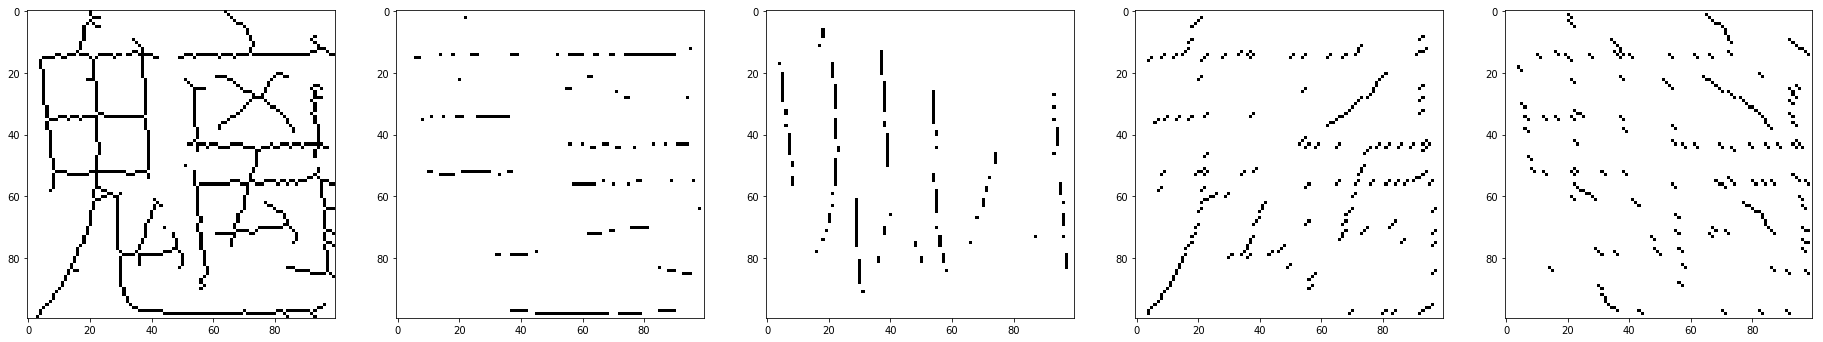

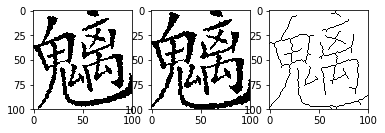

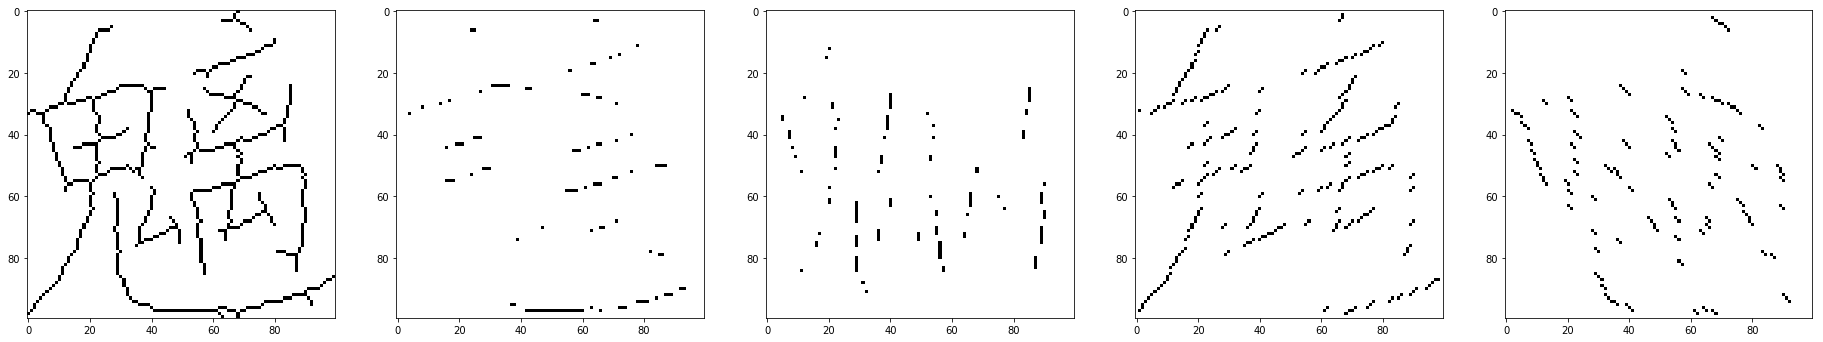

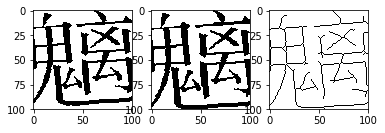

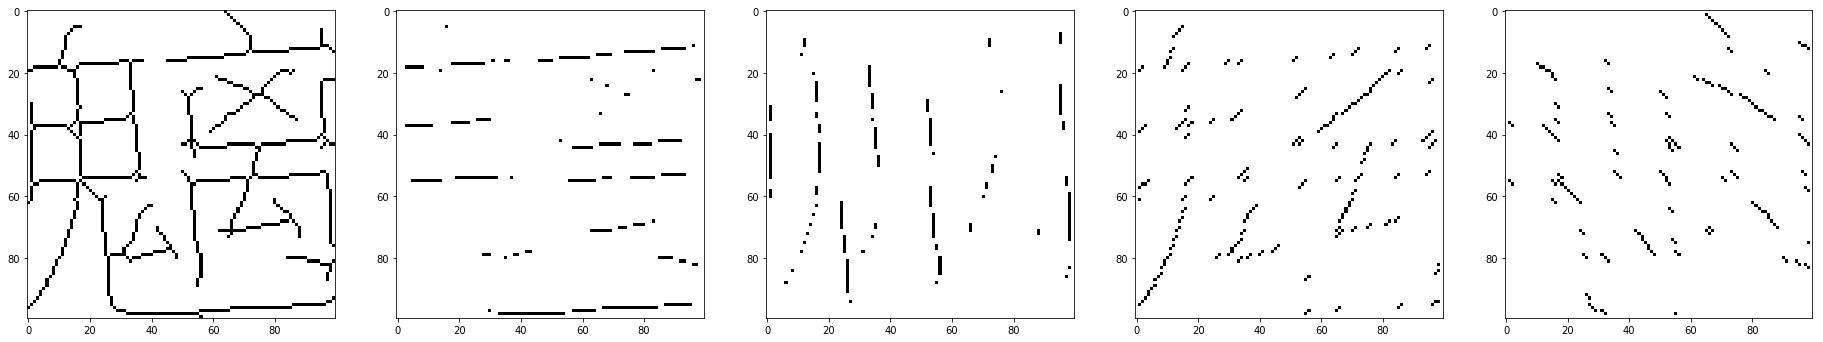

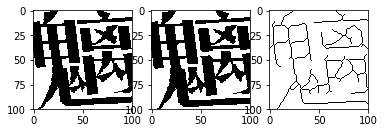

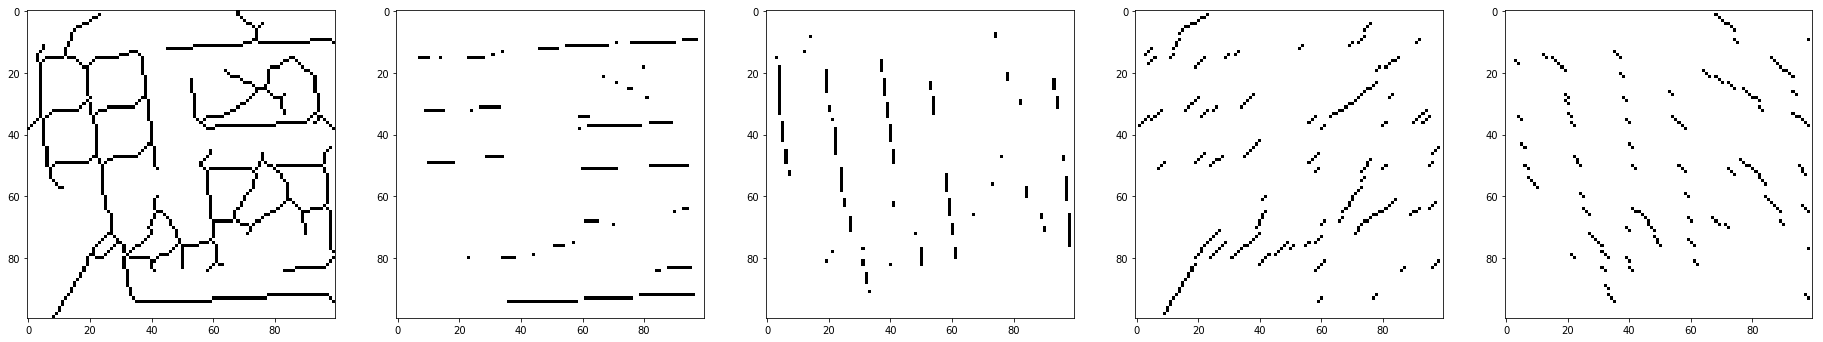

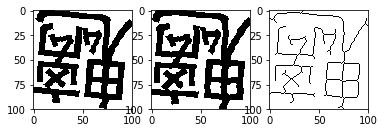

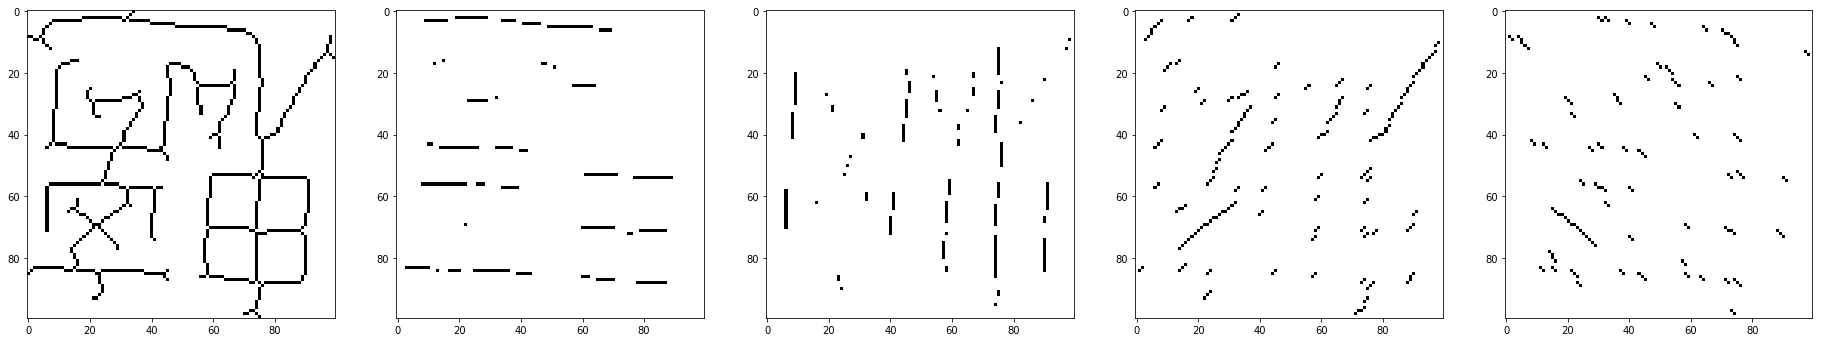

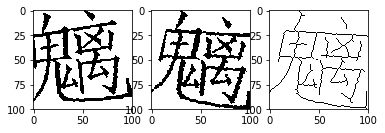

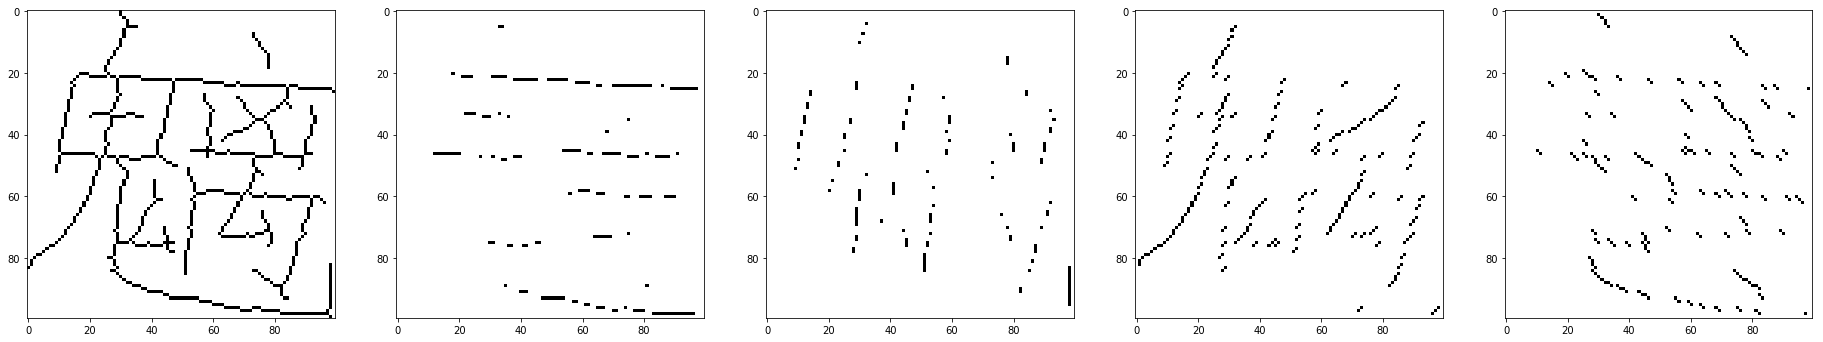

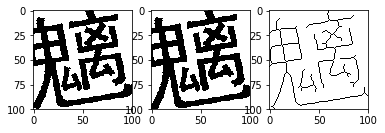

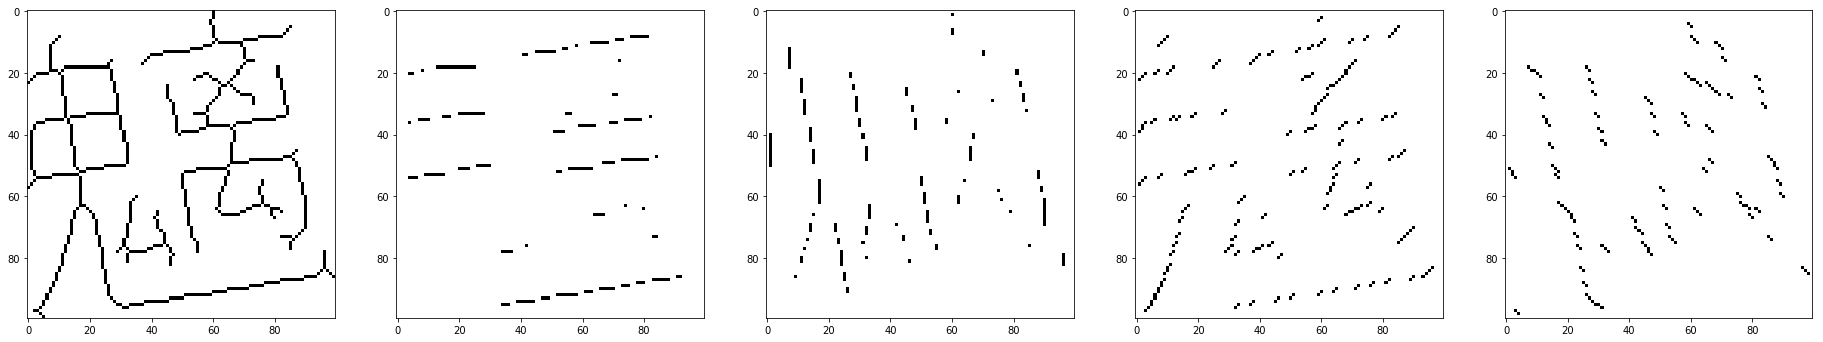

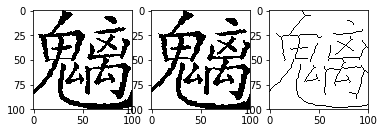

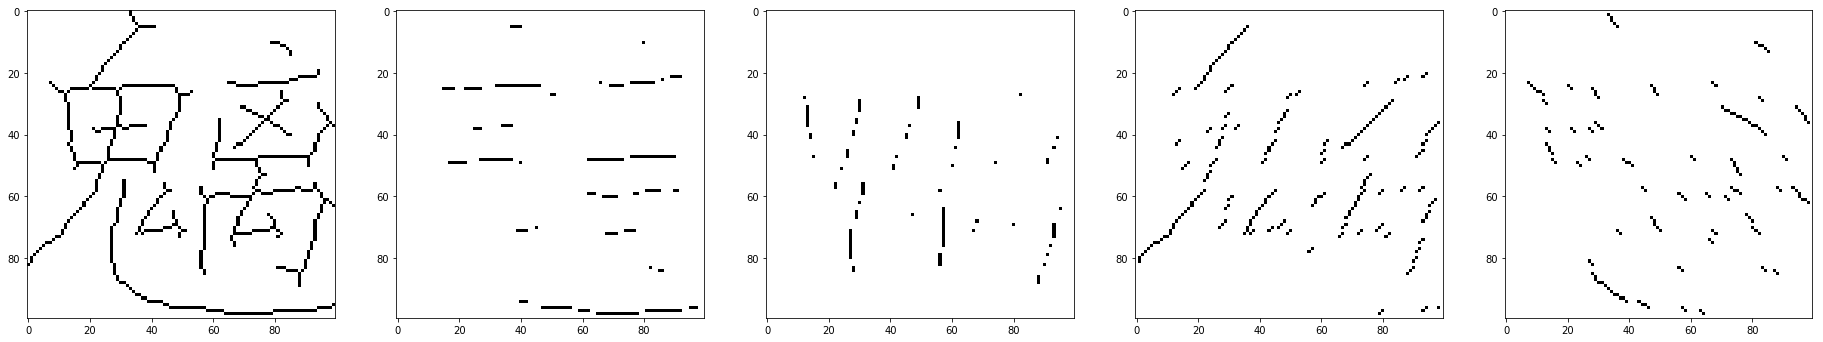

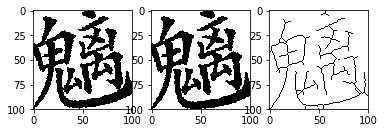

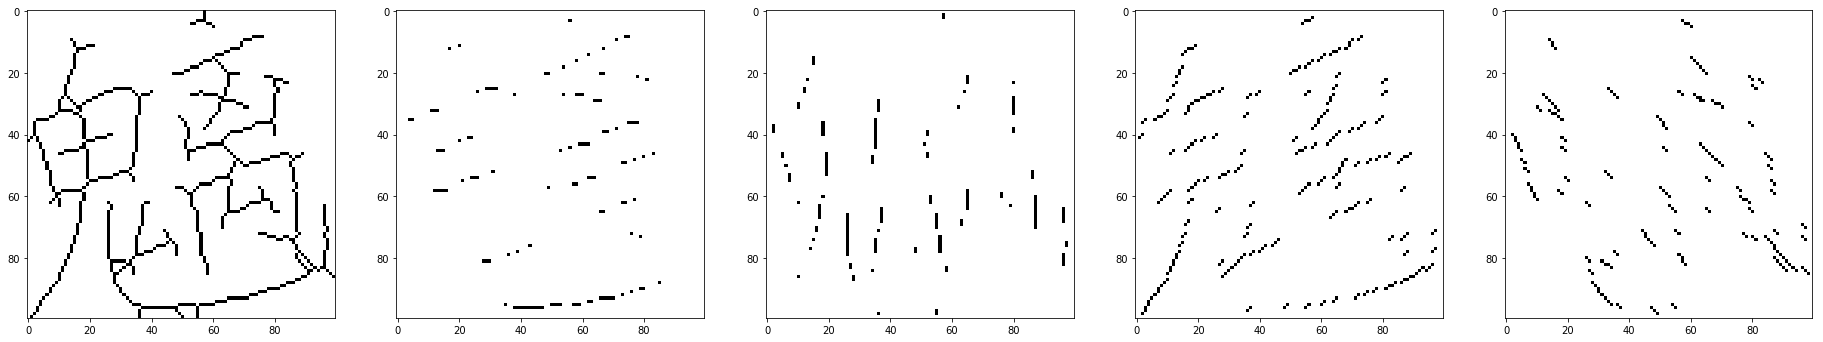

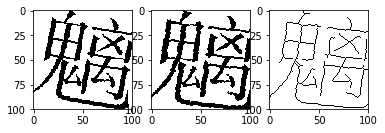

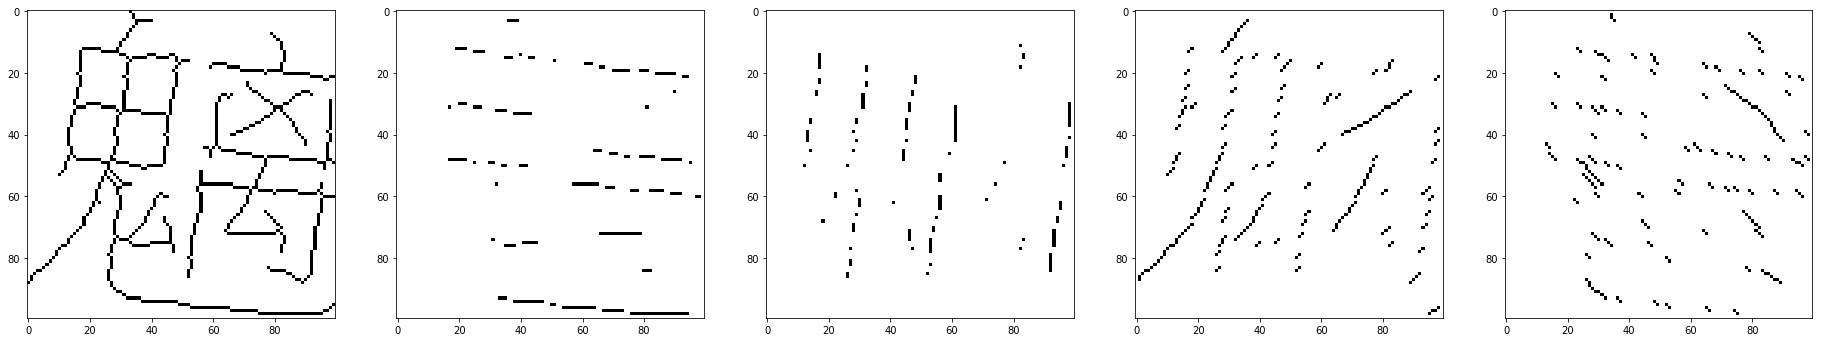

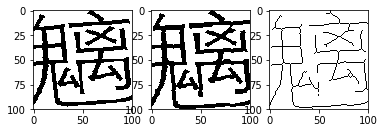

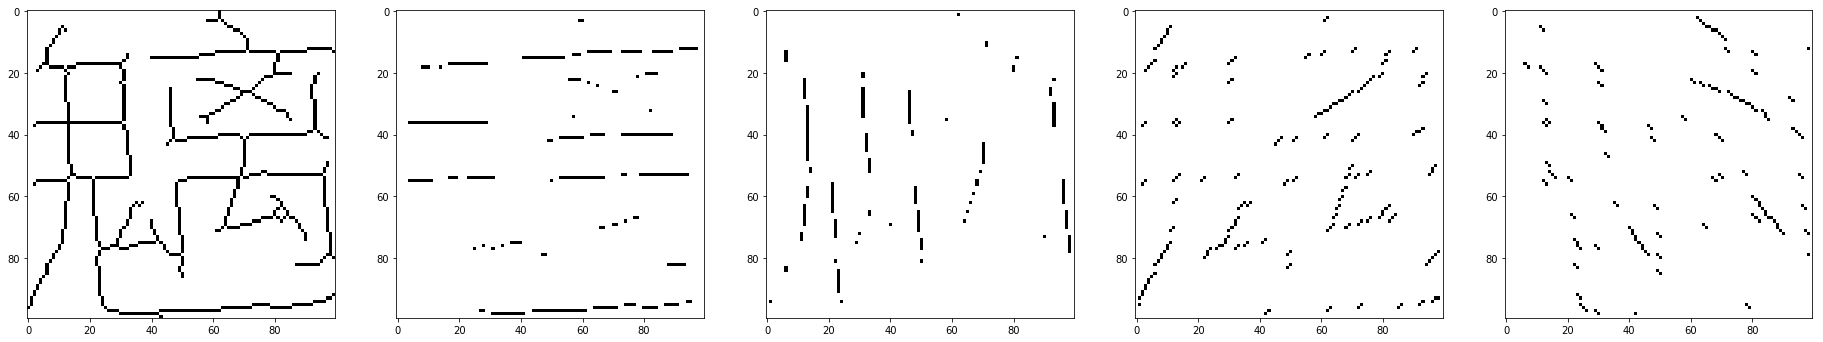

In [4]:

class Word2Feature(object):
    def __init__(self,rownum=4, colnum =9):
        self.rownum = 4
        self.colnum =9

    def run(self,img):
        sub_img = self.dissolve(img)
        features = self.get_features(img, sub_img)
        tot = np.sum(sub_img==0,axis=1)
        tot = np.sum(tot,axis=1)
        Features = np.zeros(4*9*4)
        # print(tot)
        for i in range(len(features)):
            features[i] = features[i]/ tot
            Features[4*i:4*i+4] = features[i]
        return Features

    #局部弹性网格划分
    def get_features(self,img, sub_img):
        img01 = (img==0)
        sub_img01 = (sub_img==0)
        features = []
        self.__bfs(img01,sub_img01,2,features)
        return  features

    def __bfs(self,img01,sub_img01,depth,features):
        if depth ==0:
            sum = np.sum(sub_img01,axis=1)
            sum = np.sum(sum,axis=1)
            features.append(sum)
            return
        row_cnt = np.sum(img01,axis=1)
        col_cnt = np.sum(img01,axis=0)
        split_row =self.__split(row_cnt,3)#[0,...,img01.shape[0]}
        split_col =self.__split(col_cnt,2)
        # print(img01.shape,sub_img01.shape)
        # print(split_row,split_col)
        for i in range(1,4):
            for j in range(1,3):
                # print(sub_img01.shape)
                self.__bfs(img01[split_row[i-1]:split_row[i],split_col[j-1]:split_col[j]],\
                               sub_img01[:,split_row[i-1]:split_row[i],split_col[j-1]:split_col[j]],\
                               depth-1,features)

    def __split(self,cnt,num):
        split =[]
        split.append(0)
        tot = np.sum(cnt)
        average = tot//num
        sum = 0
        c = 0
        for i in range(cnt.size):
            if sum >=average:
                split.append(i)
                sum = 0
                c = c +1
                if c == num-1:
                    break
            sum = sum + cnt[i]
        split.append(cnt.size)
        return  split

    def dissolve(self,img):
        img = img.copy()
        sub_img = np.zeros((4,img.shape[0],img.shape[1]))
        sub_img[...] = 255
#AND 在横竖方向上分解较好，OR 在撇捺分解较好
        for x in range(1,img.shape[0]-1):
            for y in range(1,img.shape[1]-1):
                if img[x,y] == 255:
                    continue
                if img[x,y-1]==0 and  img[x,y+1]==0:
                    sub_img[0,x,y] = 0
                if img[x-1,y]==0 and  img[x+1,y]==0:
                    sub_img[1,x,y] = 0
                if img[x+1,y-1]==0 or  img[x-1,y+1]==0:
                    sub_img[2,x,y] = 0
                if img[x-1,y-1]==0 or  img[x+1,y+1]==0:
                    sub_img[3,x,y] = 0

        fig, ax =plt.subplots(1,5,figsize = (32,8))
        ax[0].imshow(img,cmap='gray')
        ax[1].imshow(sub_img[0,...],cmap='gray')
        ax[2].imshow(sub_img[1,...],cmap='gray')
        ax[3].imshow(sub_img[2,...],cmap='gray')
        ax[4].imshow(sub_img[3,...],cmap='gray')
        plt.show()

        return sub_img

#图片x轴的投影，如果有数据（黑色像素点0）值为1否则为0
def get_projection_x(image,invert=False):
    p_x = [0 for x in range(image.size[0])]
    for w in range(image.size[1]):
        for h in range(image.size[0]):
            # print(image.getpixel((h,w)))
            if invert:
                if image.getpixel((h,w)) == 255:
                    p_x[h] = 1
                    continue
            else:
                if image.getpixel((h,w)) == 0:
                    p_x[h] = 1
                    continue
    return p_x

def get_img_width(projection_x):
    start_pos = 0
    stop_pos = 0
    pro_len = len(projection_x) - 1
    for idx in range(pro_len):
        if projection_x[idx] > 0:
            start_pos = idx
            break
    for idx in range(pro_len):
        if projection_x[pro_len - idx] > 0:
            stop_pos = pro_len - idx
            break
    return stop_pos - start_pos

def rotating_calipers(raw_img):
    img = raw_img.copy()
    min_width = 100
    min_angle =  100
    for angle in range(-45,45):
        temp_img = img.rotate(angle, expand = True,fillcolor ="white")
        jection = get_projection_x(temp_img, False)
        cur_width = get_img_width(jection)
        if cur_width < min_width:
            min_width = cur_width
            min_angle = angle
    img = img.rotate(min_angle,expand=True, fillcolor = "white")
    img =np.asarray(img.convert("L"))#转化为灰度图像
    img.setflags(write=1)
    img = ImageProcessing.crop_margin(img)
    img = cv2.resize(img,raw_img.size)
    th,img= cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img
        # print(jection)
        # plt.imshow(temp_img,cmap="gray")
        # plt.show()


if __name__ == '__main__':

    dir = r'Data\word'
    for img_name in os.listdir(dir):
        img_path = os.path.join(dir, img_name)
        img, pimg = ImageProcessing.get_img(img_path)
        pimg = pimg.convert("L")

        img2 = rotating_calipers(pimg)
        # print(img2)
        img3 =XiHua.Xihua(img2)
        fig,ax = plt.subplots(1,3)
        ax[0].imshow(img,cmap="gray")
        ax[1].imshow(img2,cmap="gray")
        ax[2].imshow(img3,cmap="gray")
        plt.show()
        word2feature = Word2Feature(4,9)
        features = word2feature.run(img3)
        print(features)
        # ax[3].imshow(img4,cmap="gray")
        # plt.show()

